In [1]:
import numpy as np
import pandas as pd
import re
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.layers import GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

Training samples: 8278
Testing samples: 1183
Dev samples: 2365
Columns: ['ID', 'profile', 'tweet', 'neighbor', 'domain', 'label']
Label distribution in training set: label
1    4646
0    3632
Name: count, dtype: int64


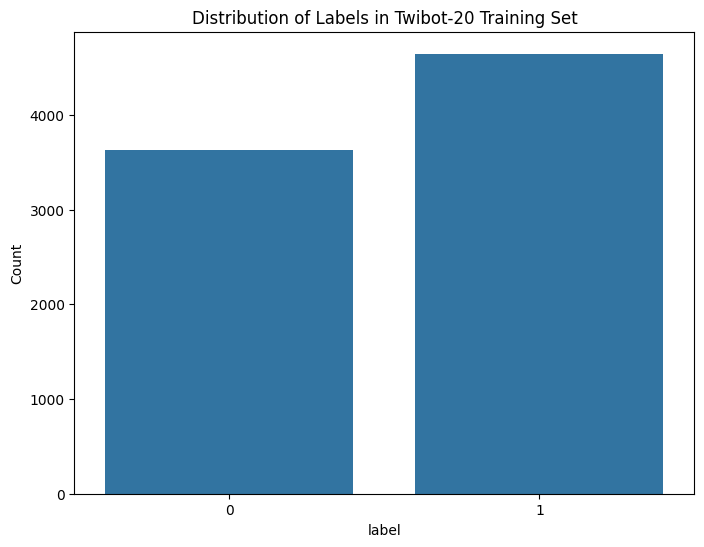


Missing values in training set:
ID            0
profile       0
tweet        55
neighbor    754
domain        0
label         0
dtype: int64


In [14]:
# Load Twibot-20 dataset with the structure you described
def load_twibot20(data_path):
    train_data = pd.read_json(os.path.join(data_path, 'train.json'))
    test_data = pd.read_json(os.path.join(data_path, 'test.json'))
    dev_data = pd.read_json(os.path.join(data_path, 'dev.json'))
    
    return train_data, test_data, dev_data

# Load the data
train_data, test_data, dev_data = load_twibot20('data')

# Check dataset structure
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")
print(f"Dev samples: {len(dev_data)}")
print(f"Columns: {train_data.columns.tolist()}")

# Check label distribution
label_counts = train_data['label'].value_counts()
print("Label distribution in training set:", label_counts)

# Visualize label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_data)
plt.title('Distribution of Labels in Twibot-20 Training Set')
plt.ylabel('Count')
plt.show()

# Check for missing values
print("\nMissing values in training set:")
print(train_data.isnull().sum())

In [15]:
def preprocess_text(text):
    """Clean and preprocess tweet text with better handling of edge cases"""
    if pd.isna(text) or not isinstance(text, str) or text.strip() == '':
        return "empty_text"  # Use a placeholder instead of empty string
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Check for empty result
    if not text.strip():
        return "empty_text"
        
    return text

In [16]:
def extract_features_from_df(df):
    """Extract features with better error handling and data validation"""
    tweet_texts = []
    metadata_features = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        # Process tweets
        tweets = []
        try:
            tweet_value = row['tweet']
            if isinstance(tweet_value, str) and not pd.isna(tweet_value):
                try:
                    tweet_data = json.loads(tweet_value.replace("'", "\""))
                    if isinstance(tweet_data, list):
                        for tweet in tweet_data:
                            if isinstance(tweet, dict) and 'text' in tweet:
                                tweets.append(preprocess_text(tweet['text']))
                except:
                    tweets.append(preprocess_text(tweet_value))
        except (KeyError, TypeError):
            pass  # Handle case where 'tweet' column doesn't exist
        
        # Add placeholder for empty tweets
        if not tweets:
            tweets = ["empty_text"]
        
        # Process profile with better error handling
        followers = 0
        friends = 0
        verified = 0
        has_profile_pic = 0
        statuses_count = 0
        desc_length = 0
        
        try:
            profile_value = row['profile']
            if isinstance(profile_value, str) and not pd.isna(profile_value):
                try:
                    profile = json.loads(profile_value.replace("'", "\""))
                    if isinstance(profile, dict):
                        followers = int(float(profile.get('followers_count', 0)))
                        friends = int(float(profile.get('friends_count', 0)))
                        verified = 1 if profile.get('verified', False) else 0
                        has_profile_pic = 0 if profile.get('default_profile_image', True) else 1
                        statuses_count = int(float(profile.get('statuses_count', 0)))
                        desc_length = len(str(profile.get('description', '')))
                except (ValueError, TypeError):
                    pass  # Use default values if conversion fails
        except (KeyError, TypeError):
            pass  # Handle case where 'profile' column doesn't exist
            
        # Calculate ff_ratio safely with upper bound
        ff_ratio = 0
        if friends > 0:
            ff_ratio = min(followers / max(friends, 1), 100)  # Cap ratio at 100
            
        # Create metadata feature vector with safety bounds
        metadata = [
            max(0, min(followers, 1e7)),        # Reasonable upper bound
            max(0, min(friends, 1e6)),
            ff_ratio,
            max(0, min(statuses_count, 1e6)),
            verified,
            has_profile_pic,
            max(0, min(desc_length, 5000))
        ]
        
        tweet_texts.append(" ".join(tweets))
        metadata_features.append(metadata)
    
    # Final validation of metadata features
    metadata_array = np.array(metadata_features, dtype=np.float32)
    
    # Replace infinities and NaNs
    metadata_array = np.nan_to_num(metadata_array, nan=0.0, posinf=100.0, neginf=0.0)
    
    return tweet_texts, metadata_array

In [17]:
def check_data_integrity(features, name="dataset"):
    """Check for anomalies in extracted features"""
    print(f"\n--- Data integrity check for {name} ---")
    print(f"Shape: {features.shape}")
    print(f"NaN values: {np.isnan(features).sum()}")
    print(f"Inf values: {np.isinf(features).sum()}")
    print(f"Min values: {features.min(axis=0)}")
    print(f"Max values: {features.max(axis=0)}")
    print(f"Mean values: {features.mean(axis=0)}")
    print("-------------------------------------\n")

In [49]:
# 4. Improved model architecture with regularization
def build_better_model(vocab_size,max_length, embed_dim=128, rnn_units=64, metadata_dim=7):
    """Build a more stable model with regularization and batch normalization"""
    # Text input branch
    text_input = Input(shape=(max_length,), name='text_input')
    emb = Embedding(vocab_size, embed_dim, mask_zero=True)(text_input)
    
    # Use GRU with gradient clipping built-in
    rnn = Bidirectional(GRU(rnn_units, 
                            recurrent_initializer='glorot_uniform',
                            recurrent_activation='sigmoid',
                            reset_after=True))(emb)
    
    # Add regularization
    x = BatchNormalization()(rnn)
    x = Dropout(0.3)(x)
    text_features = Dense(32, activation='relu', 
                         kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    # Metadata input branch with preprocessing
    meta_input = Input(shape=(metadata_dim,), name='meta_input')
    m = BatchNormalization()(meta_input)  # Normalize inputs
    meta_features = Dense(16, activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.001))(m)
    
    # Combine features
    combined = Concatenate()([text_features, meta_features])
    x = BatchNormalization()(combined)
    x = Dense(32, activation='relu',
             kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[text_input, meta_input], outputs=output)
    
    # Use a small learning rate with gradient clipping
    optimizer = Adam(learning_rate=5e-5, clipnorm=1.0)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]
    )
    
    return model

In [50]:
# 5. Custom callback to check for NaN values
class NanMonitor(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            if np.isnan(loss) or np.isinf(loss):
                print(f"\nBatch {batch}: Invalid loss, terminating training")
                self.model.stop_training = True
                
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Check if metrics contain NaNs
        for metric, value in logs.items():
            if np.isnan(value) or np.isinf(value):
                print(f"\nEpoch {epoch}: NaN in {metric}, terminating training")
                self.model.stop_training = True
                break

In [51]:
# 6. Main execution function
def train_and_evaluate_model(train_data, test_data, dev_data):
    """Train and evaluate the bot detection model with proper error handling"""
    # Extract features
    print("Extracting features from training data...")
    train_texts, train_metadata = extract_features_from_df(train_data)
    print("Extracting features from test data...")
    test_texts, test_metadata = extract_features_from_df(test_data)
    print("Extracting features from dev data...")
    dev_texts, dev_metadata = extract_features_from_df(dev_data)
    
    # Check metadata feature integrity
    check_data_integrity(train_metadata, "training metadata")
    check_data_integrity(test_metadata, "test metadata")
    
    # Using sklearn's LabelEncoder
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train_data['label'])
    y_test = label_encoder.transform(test_data['label'])
    y_dev = label_encoder.transform(dev_data['label'])
    
    # Print class distribution
    print(f"Training class distribution: {np.bincount(y_train.astype(int))}")
    print(f"Test class distribution: {np.bincount(y_test.astype(int))}")
    print(f"Dev class distribution: {np.bincount(y_dev.astype(int))}")
    
    # Tokenize text data
    max_words = 10000
    max_length = 100
    
    # Add special tokens
    tokenizer = Tokenizer(num_words=max_words, oov_token="<UNK>")
    
    # Include empty_text placeholder in vocabulary
    all_texts = train_texts + ["empty_text"]  
    tokenizer.fit_on_texts(all_texts)
    
    # Convert text to sequences
    X_train_text = tokenizer.texts_to_sequences(train_texts)
    X_test_text = tokenizer.texts_to_sequences(test_texts)
    X_dev_text = tokenizer.texts_to_sequences(dev_texts)
    
    # Pad sequences
    X_train_text_pad = pad_sequences(X_train_text, maxlen=max_length)
    X_test_text_pad = pad_sequences(X_test_text, maxlen=max_length)
    X_dev_text_pad = pad_sequences(X_dev_text, maxlen=max_length)
    
    # Robust scaling of metadata
    scaler = RobustScaler()
    X_train_meta = scaler.fit_transform(train_metadata)
    X_test_meta = scaler.transform(test_metadata)
    X_dev_meta = scaler.transform(dev_metadata)
    
    # Final cleanup of metadata
    X_train_meta = np.nan_to_num(X_train_meta, nan=0.0)
    X_test_meta = np.nan_to_num(X_test_meta, nan=0.0)
    X_dev_meta = np.nan_to_num(X_dev_meta, nan=0.0)
    
    # Clip extreme values
    X_train_meta = np.clip(X_train_meta, -10, 10)
    X_test_meta = np.clip(X_test_meta, -10, 10)
    X_dev_meta = np.clip(X_dev_meta, -10, 10)
    
    print(f"Training text shape: {X_train_text_pad.shape}")
    print(f"Training metadata shape: {X_train_meta.shape}")
    print(f"Test text shape: {X_test_text_pad.shape}")
    print(f"Test metadata shape: {X_test_meta.shape}")
    
    # Create model
    vocab_size = min(len(tokenizer.word_index) + 1, max_words)
    print(f"Vocabulary size: {vocab_size}")
    
    model = build_better_model(vocab_size, max_length, metadata_dim=X_train_meta.shape[1])
    print(model.summary())
    
    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        'bot_detector_best.h5', 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
    
    nan_monitor = NanMonitor()
    
    # Handle class imbalance
    class_weight = {
        0: 1.0, 
        1: len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))
    }
    print(f"Using class weights: {class_weight}")
    
    # Train with small batch size initially
    print("\nStarting training with small batch size...")
    history = model.fit(
        [X_train_text_pad, X_train_meta], y_train,
        validation_data=([X_dev_text_pad, X_dev_meta], y_dev),
        epochs=3,
        batch_size=16,  # Very small batch size
        callbacks=[early_stopping, model_checkpoint, reduce_lr, nan_monitor],
        class_weight=class_weight
    )
    
    # If initial training works, continue with larger batch size
    if not np.isnan(history.history['loss'][-1]):
        print("\nContinuing training with larger batch size...")
        history = model.fit(
            [X_train_text_pad, X_train_meta], y_train,
            validation_data=([X_dev_text_pad, X_dev_meta], y_dev),
            initial_epoch=len(history.history['loss']),
            epochs=50,
            batch_size=42,
            callbacks=[early_stopping, model_checkpoint, reduce_lr, nan_monitor],
            class_weight=class_weight
        )
    
    # Evaluate model
    print("\nEvaluating model...")
    results = model.evaluate([X_test_text_pad, X_test_meta], y_test)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    
    # Get precision and recall
    precision = results[2]
    recall = results[3]
    
    # Safe F1 calculation
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0
    
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    
    # Alternative evaluation using scikit-learn
    print("\nEvaluating with raw predictions...")
    y_pred_prob = model.predict([X_test_text_pad, X_test_meta])
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    sk_precision = precision_score(y_test, y_pred)
    sk_recall = recall_score(y_test, y_pred)
    sk_f1 = f1_score(y_test, y_pred)
    
    print(f"Sklearn Precision: {sk_precision:.4f}")
    print(f"Sklearn Recall: {sk_recall:.4f}")
    print(f"Sklearn F1-Score: {sk_f1:.4f}")
    
    return model, history


In [52]:
model, history = train_and_evaluate_model(train_data, test_data, dev_data)

Extracting features from training data...


Extracting features: 100%|██████████| 8278/8278 [00:00<00:00, 25458.70it/s]


Extracting features from test data...


Extracting features: 100%|██████████| 1183/1183 [00:00<00:00, 15942.95it/s]


Extracting features from dev data...


Extracting features: 100%|██████████| 2365/2365 [00:00<00:00, 25088.02it/s]



--- Data integrity check for training metadata ---
Shape: (8278, 7)
NaN values: 0
Inf values: 0
Min values: [0. 0. 0. 0. 0. 0. 0.]
Max values: [0. 0. 0. 0. 0. 0. 0.]
Mean values: [0. 0. 0. 0. 0. 0. 0.]
-------------------------------------


--- Data integrity check for test metadata ---
Shape: (1183, 7)
NaN values: 0
Inf values: 0
Min values: [0. 0. 0. 0. 0. 0. 0.]
Max values: [0. 0. 0. 0. 0. 0. 0.]
Mean values: [0. 0. 0. 0. 0. 0. 0.]
-------------------------------------

Training class distribution: [3632 4646]
Test class distribution: [543 640]
Dev class distribution: [1062 1303]
Training text shape: (8278, 100)
Training metadata shape: (8278, 7)
Test text shape: (1183, 100)
Test metadata shape: (1183, 7)
Vocabulary size: 4
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 100)]    

c:\Users\omgha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


517/518 [============================>.] - ETA: 0s - loss: 0.6692 - accuracy: 0.4520 - precision_1: 0.5506 - recall_1: 0.1311
Epoch 2: val_loss improved from 0.76342 to 0.76055, saving model to bot_detector_best.h5
518/518 [==============================] - 18s 34ms/step - loss: 0.6692 - accuracy: 0.4522 - precision_1: 0.5501 - recall_1: 0.1311 - val_loss: 0.7605 - val_accuracy: 0.4490 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 5.0000e-05
Epoch 3/3
517/518 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.4808 - precision_1: 0.5689 - recall_1: 0.3093
Epoch 3: val_loss improved from 0.76055 to 0.73732, saving model to bot_detector_best.h5
518/518 [==============================] - 19s 36ms/step - loss: 0.6545 - accuracy: 0.4807 - precision_1: 0.5687 - recall_1: 0.3091 - val_loss: 0.7373 - val_accuracy: 0.4490 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 5.0000e-05

Continuing training with larger batch size...
Epoch 4/50
198/19